# How do health metrics affect math course performance in highschoolers?

## Introduction

#### Question

How do health metrics affect math course performance in highschoolers?

#### Dataset

This data focuses on the academic performance of secondary school students in two Portuguese schools. It includes various factors such as student grades, demographic information, social aspects, and school-related features. The data was collected through school reports and questionnaires. Two datasets are provided, specifically examining student performance in two different subjects: Mathematics and Portuguese.



In [29]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [10]:
# Load the data from the web
set.seed(2000)
path <- 'https://raw.githubusercontent.com/JadenMajid/dsci-100-student-grades/main/student-mat.csv'

og_data <- read_csv2(file = path) |>
    mutate(Talc = Walc + Dalc)
    # mutate(Walc = as_factor(Walc)) |>
    # mutate(Dalc = as_factor(Dalc)) |>
    # mutate(Talc = as_factor(Talc))

# training data
split <- og_data |>
    initial_split(prop = 0.75, strata = G3)

data <- training(split)
test_data <- testing(split)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
sum_stats <- data |>
    group_by(sex) |>
    summarize(avg_G3 = mean(G3), avg_walc = mean(Walc), avg_dalc = mean(Dalc), 
              avg_health = mean(health), avg_studytime = mean(studytime), avg_absences = mean(absences))
sum_stats


sex,avg_G3,avg_walc,avg_dalc,avg_health,avg_studytime,avg_absences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,9.90303,1.969697,1.260606,3.412121,2.278788,6.424242
M,10.94574,2.751938,1.767442,3.837209,1.767442,4.992248


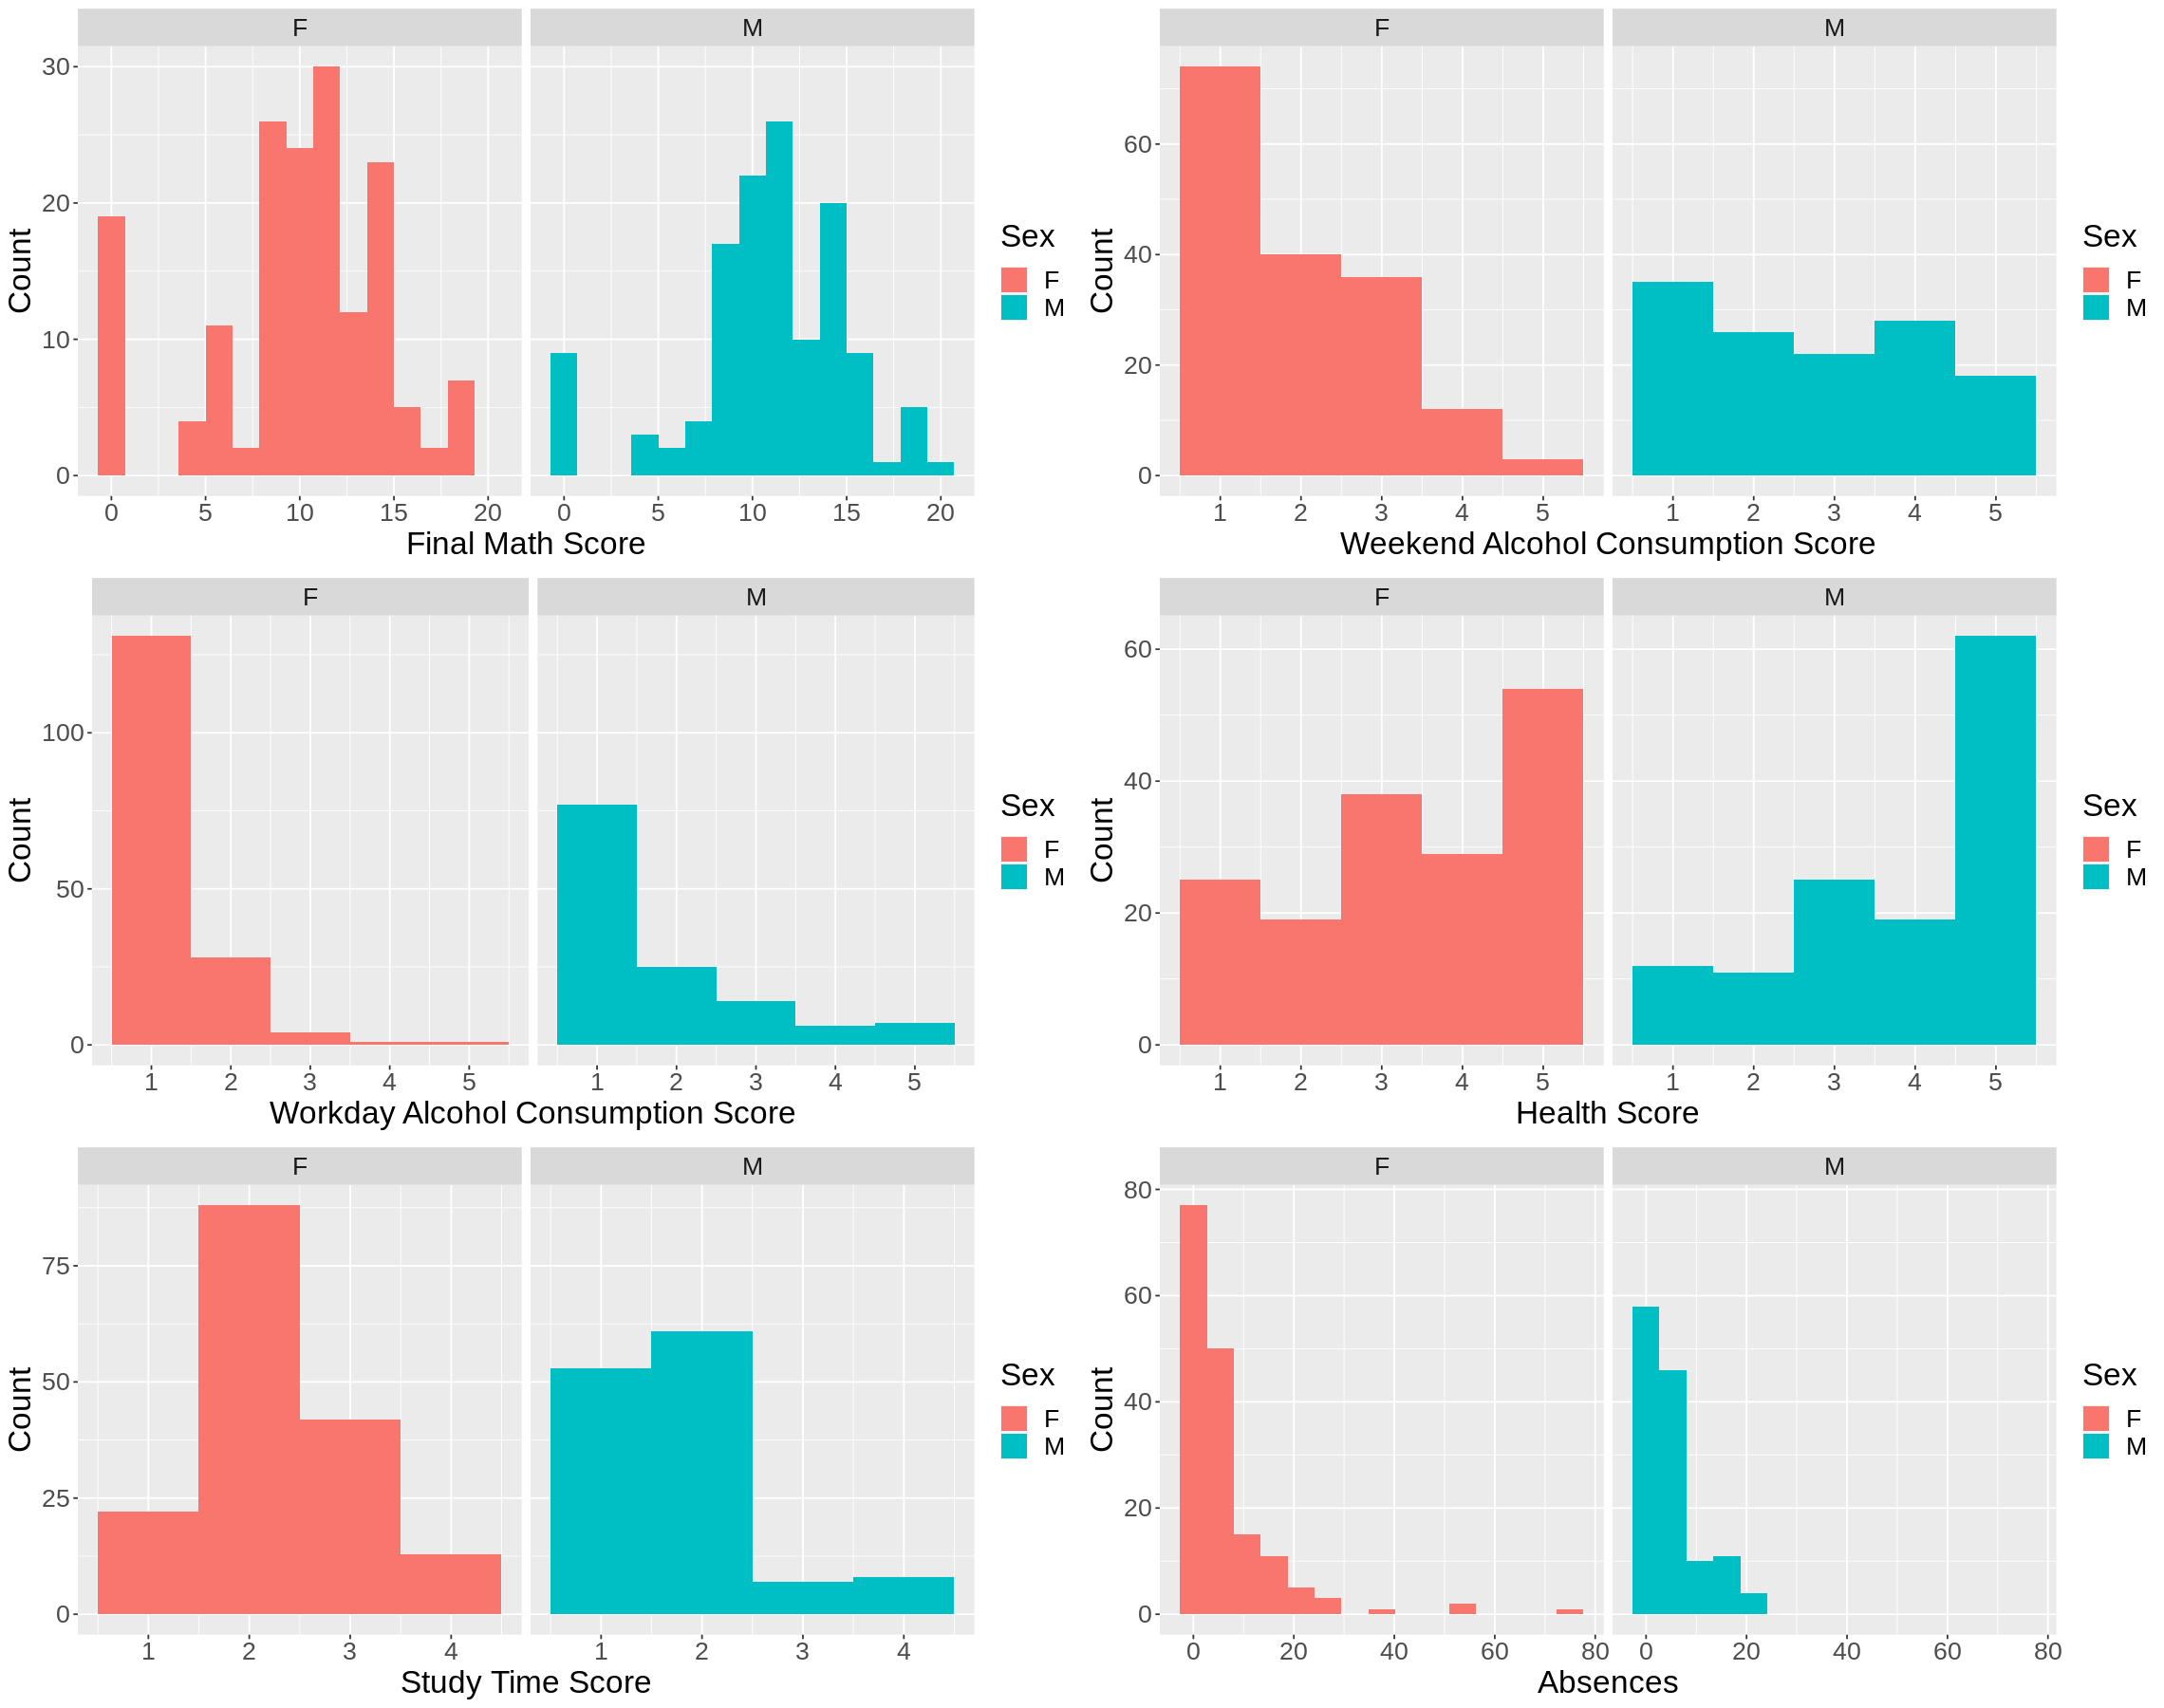

In [9]:
options(repr.plot.width = 19, repr.plot.height = 15)

G3_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = G3, fill = as_factor(sex)), bins = 15) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Final Math Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


walc_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = Walc, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Weekend Alcohol Consumption Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


dalc_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = Dalc, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Workday Alcohol Consumption Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


health_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = health, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Health Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


studytime_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = studytime, fill = as_factor(sex)), bins = 4) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Study Time Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


absences_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = absences, fill = as_factor(sex)), bins = 15) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Absences", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


top_row <- plot_grid(G3_plot, walc_plot)
middle_row <- plot_grid(dalc_plot, health_plot)
bottom_row <- plot_grid(studytime_plot, absences_plot)
summary_plot <- plot_grid(top_row, middle_row, bottom_row, ncol = 1)
summary_plot

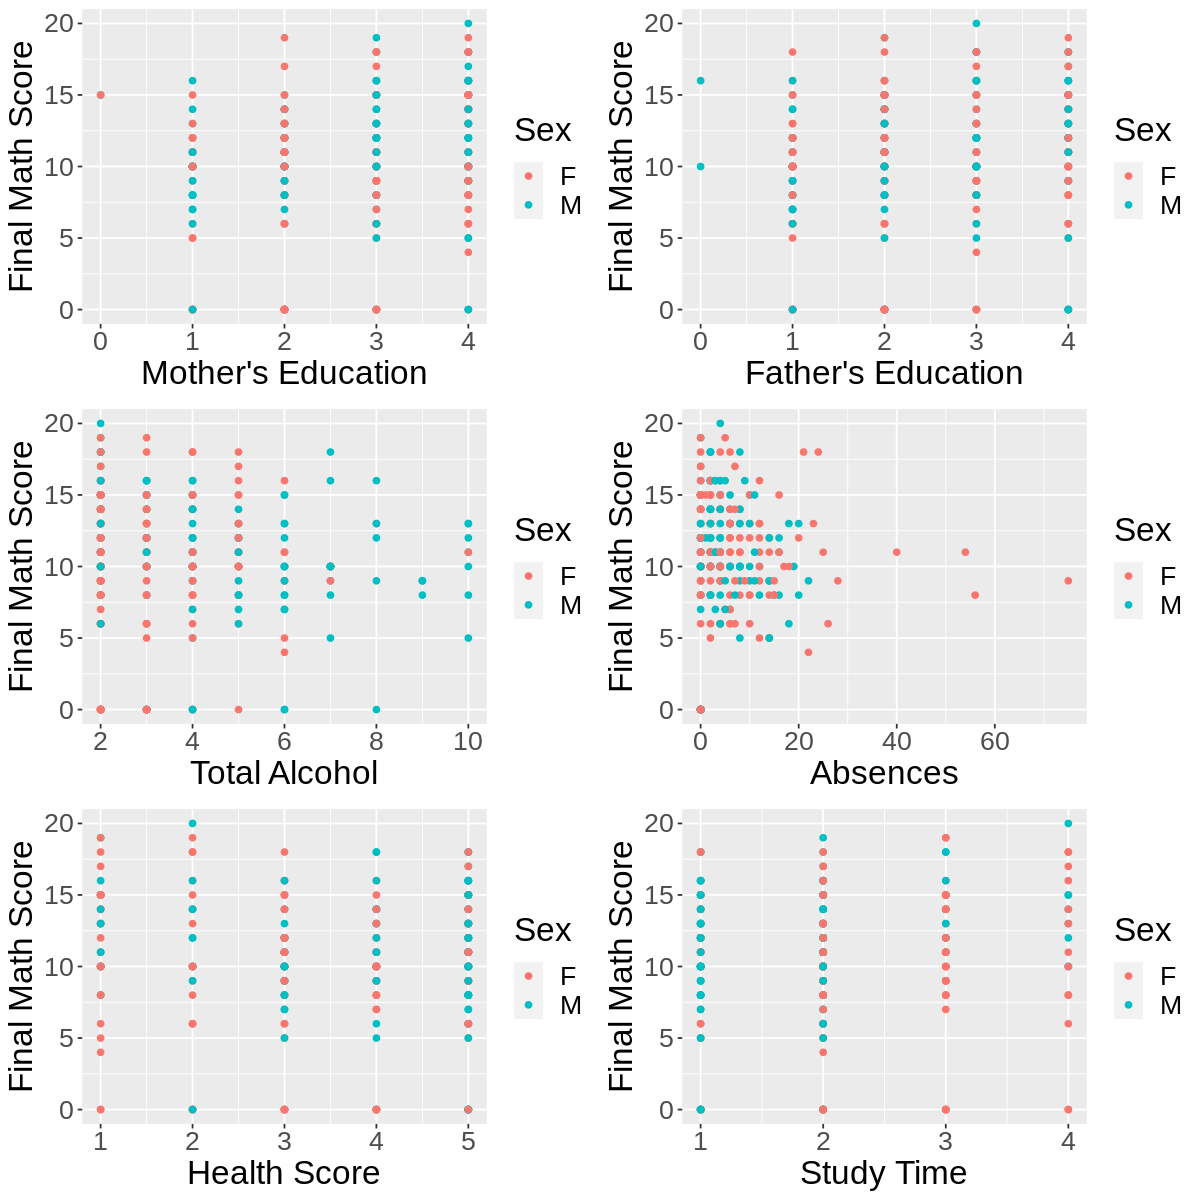

In [28]:
options(repr.plot.width = 10, repr.plot.height = 10)

medu_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Medu, y = G3, color = sex)) +
        labs(x = "Mother's Education", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


fedu_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Fedu, y = G3, color = sex)) +
        labs(x = "Father's Education", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


talc_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Talc, y = G3, color = sex)) +
        labs(x = "Total Alcohol", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


absences_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = absences, y = G3, color = sex)) +
        labs(x = "Absences", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


health_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = health, y = G3, color = sex)) +
        labs(x = "Health Score", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


study_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = studytime, y = G3, color = sex)) +
        labs(x = "Study Time", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


top_row_2 <- plot_grid(medu_vs_G3, fedu_vs_G3)
middle_row_2 <- plot_grid(talc_vs_G3, absences_vs_G3)
bottom_row_2 <- plot_grid(health_vs_G3, study_vs_G3)
summary_plot_2 <- plot_grid(top_row_2, middle_row_2, bottom_row_2, ncol = 1)
summary_plot_2

# Methods

Data analysis will be conducted by using the following variables: health, sex, weekend/workday alcohol consumption, study time, and absences. A classification model will be trained using a subset of this dataset to predict G3 Mathematics scores. Before training, the data will be properly normalized. This model will be tested on the testing subset of the dataset. To choose the optimal number of nearest neighbours to consider, the training dataset will be further split up to validate out choice of number of neighbours. A classification model is chosen since the reported G3 scores are natural numberse from 0 to 20. 

The variables that appear to show the most correlation with the final math scores will be used in the model, and can reference the above plots for those variables.

#### Expectations

It is expected to find Mathematic scores and these "health" variables will be inversely correlated. As health declines, one would expect a student's scores to decline as well. This may occur with increasing weekend and workday alcohol consumption, lower health scores, increased absences, and lower study time. If such a relationship is seen in the analysis, perhaps these school districts will place more emphasis on student livelihood and wellbeing as a way to improve their academic performance. This may lead to other interesting investigations, such as looking into relationships between academic performance and a parent's marital status, or other external factors that may affect a student's schooling.

# Alternative Wine Dataset
This dataset has more continuous variables, which may make it easier to create a regression/classification model to. There are also stronger correlations between the variables.

In [30]:
wine_path <- 'https://raw.githubusercontent.com/adrianwu2000/toy_ds_project/main/wine.data'

wine_data <- read_delim(file = wine_path, delim = ",", col_names = FALSE) |>
    mutate(X1 = as_factor(X1))
colnames(wine_data) <- c('alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium', 'total_phenols',
                         'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                         'hue', 'OD280_or_OD315_of_diluted wines', 'proline')

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


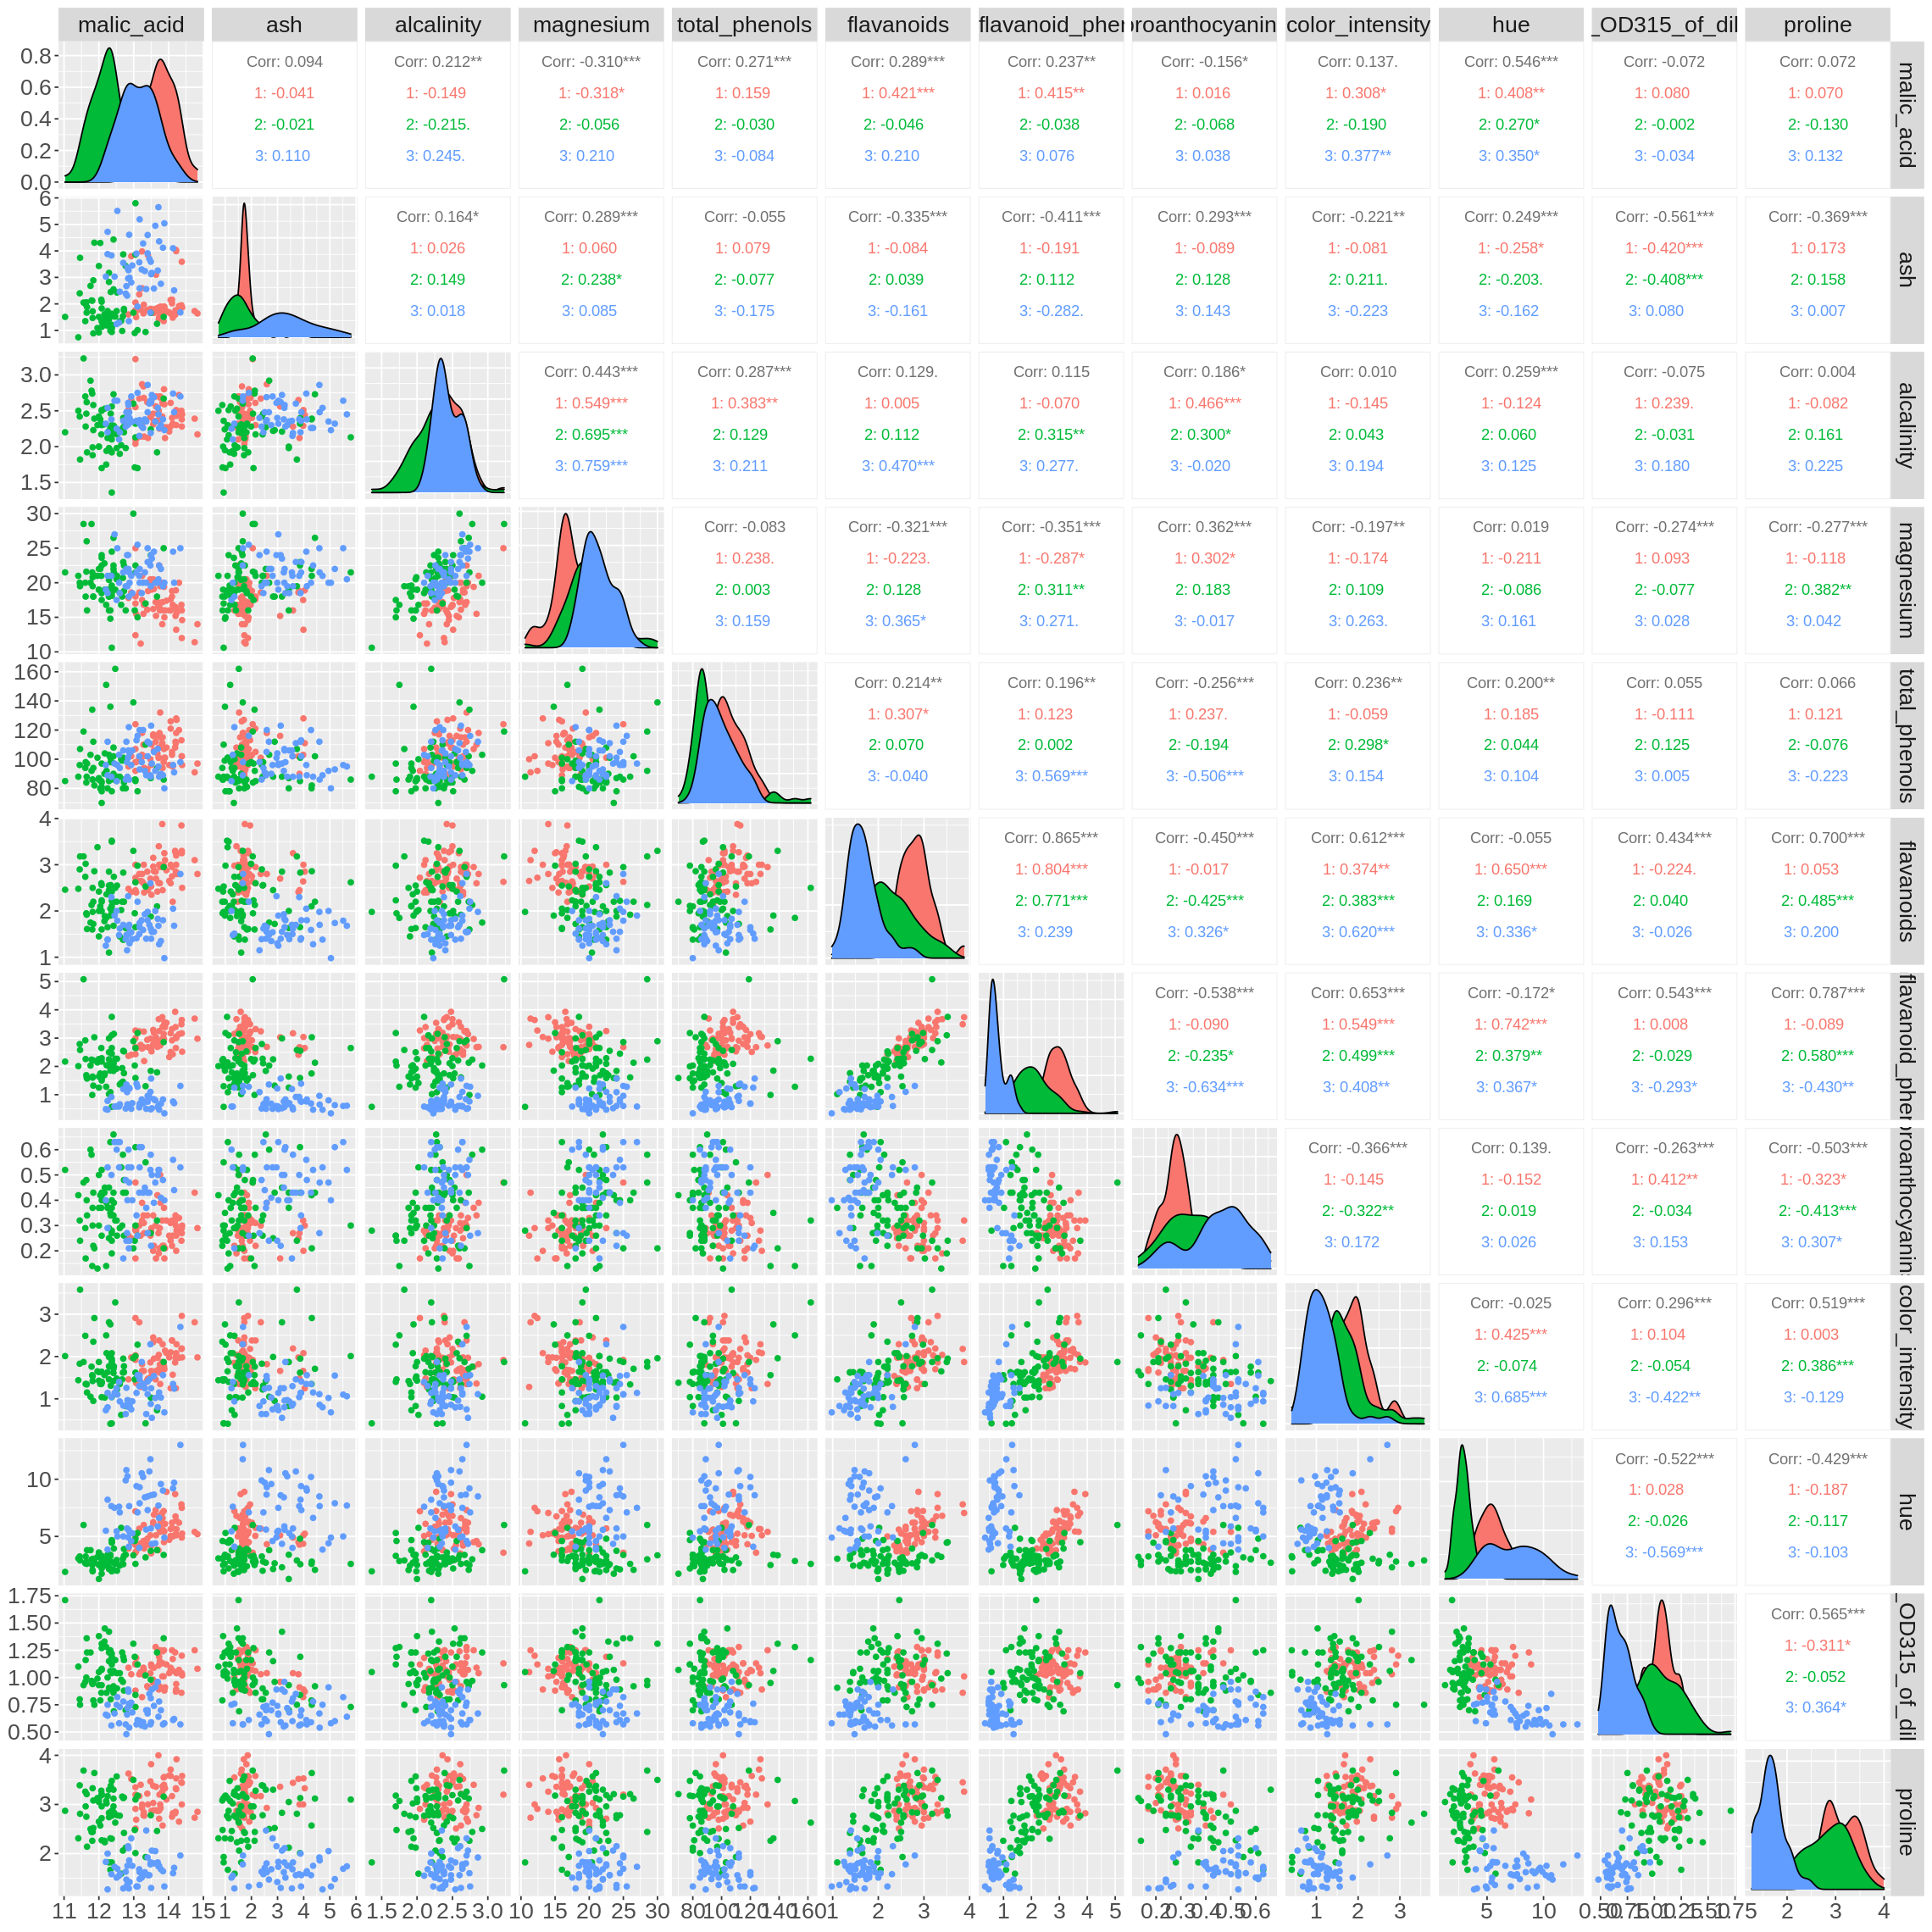

In [31]:
options(repr.plot.width = 19, repr.plot.height = 19)
wine_data |> 
  #select(alcalinity, malic_acid, ash) |>
  ggpairs(columns = 2:13, ggplot2::aes(colour = alcohol))+
    theme(text = element_text(size = 20))#, upper = list(continuous = "density", combo = "box_no_facet")